<a href="https://colab.research.google.com/github/DCDPUAEM/DCDP/blob/main/03-Deep-Learning/notebooks/08-LSTM-Clasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Long Short-Term Memory Networks: Sentiment Analysis</h1>

En esta notebook usaremos redes LSTM para análisis de sentimientos. Estudiaremos el dataset de reviews de películas de IMDB. Este es un dataset muy usado para tareas de análisis de sentimientos.

En esta tarea no nos interesa tener una salida en cada elemento de la secuencia, solamente queremos la salida al final de la secuencia.


<img align="left" width="50%" src="https://github.com/DCDPUAEM/DCDP/blob/main/03-Deep-Learning/img/LSTM.png?raw=1"/>

In [2]:
import tensorflow as tf

print('GPU presente en: {}'.format(tf.test.gpu_device_name()))

GPU presente en: /device:GPU:0


In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import re
import numpy as np


import keras
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import math
import nltk

# LSTM for Sentiment Analysis

## El conjunto de datos

IMDB

* Original source: http://ai.stanford.edu/~amaas/data/sentiment/
* Kaggle: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Bajamos este archivo desde Drive. En caso de tener problemas con el siguiente comando, puedes bajar el archivo de [aquí](https://drive.google.com/uc?id=1TewLD3BbgqV1t2I905Al3vm_VqUzoPzg) y luego subirlo manualmente a Colab.

In [5]:
!pip install -q gdown

In [6]:
!gdown 1TewLD3BbgqV1t2I905Al3vm_VqUzoPzg

Downloading...
From: https://drive.google.com/uc?id=1TewLD3BbgqV1t2I905Al3vm_VqUzoPzg
To: /content/IMDB Dataset.csv
100% 66.2M/66.2M [00:00<00:00, 168MB/s]


Leemos el dataframe

In [7]:
import pandas as pd

df = pd.read_csv('/content/IMDB Dataset.csv')
display(df)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


Tenemos dos clases. Es un problema de clasificación binaria

In [8]:
df['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

Las clases están balanceadas

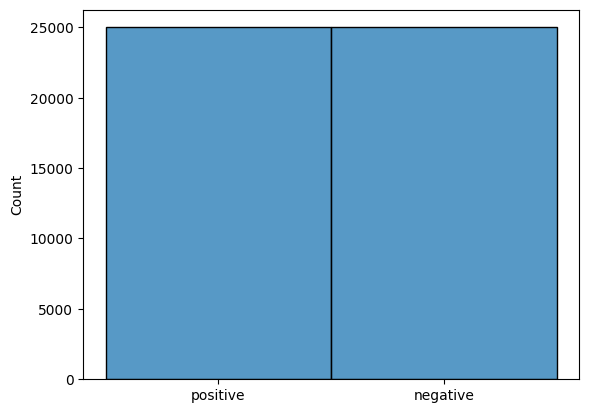

In [9]:
import seaborn as sns

sns.histplot(df['sentiment'].values)
plt.show()

In [10]:
from sklearn.preprocessing import LabelEncoder

labels = df['sentiment'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels) #codificar positive como 1, negative como 0

In [11]:
print(f"Before encoding {labels[:3]}")
print(f"After encoding {encoded_labels[:3]}")

Before encoding ['positive' 'positive' 'positive']
After encoding [1 1 1]


## Limpiar texto

In [12]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

Limpiamos quitando stopwords, símbolos, tags HTML, etc usando herramientas del módulo `nltk`. Para hacer la limpieza también usamos expresiones regulares *regex*. Puedes practicar el uso de expresiones regulares [aquí](https://regex101.com/).

In [13]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def clean(text):
    clean_text = re.sub(CLEANR, '', text.lower()) # Quitamos etiquetas HTML
    clean_text = re.sub(r'[^\w\s]', '', clean_text.lower()) # Quitamos signos de puntuación y símbolos
    clean_text = re.sub('[0-9]', '', clean_text.lower())  # Quitamos números
    SW = stopwords.words('english') # Leemos la lista de stopwords del inglés
    tokens_no_sw = [word for word in word_tokenize(clean_text) if not word in SW] # Quitamos stopwords
    stems = ""
    for w in tokens_no_sw:
        stems += lemmatizer.lemmatize(w) + " "
    return stems

In [14]:
df['clean'] = df['review'].apply(clean)
df

,review,sentiment,clean
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching oz episode you...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...
...,...,...,...
49995,I thought this movie did a down right good job...,positive,thought movie right good job wasnt creative or...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,bad plot bad dialogue bad acting idiotic direc...
49997,I am a Catholic taught in parochial elementary...,negative,catholic taught parochial elementary school nu...
49998,I'm going to have to disagree with the previou...,negative,im going disagree previous comment side maltin...


In [15]:
reviews = df['clean'].values

Separamos en entrenamiento y prueba

In [16]:
from sklearn.model_selection import train_test_split

train_reviews, test_reviews, train_labels, test_labels = train_test_split(reviews, encoded_labels, train_size=0.8)#, stratify = encoded_labels)}}

print(f"Shape of X_train: {train_reviews.shape}")
print(f"Shape of X_test: {test_reviews.shape}")

Shape of X_train: (40000,)
Shape of X_test: (10000,)


Preparamos los reviews. Este proceso consta de dos partes:

1. Vectorización: La clase `Tokenizer` de `keras` permite vectorizar un corpus de textos, convirtiendo cada texto en una secuencia de índices (cada índice representa un token en un diccionario, los índices son $1,...,n$). No se toman en cuenta todas las palabras del vocabulario, se toman solamente las `vocab_size` más frecuentes.

2. Padding: Las secuencias de índices tienen diferentes longitudes, dependiendo de la longitud del review. Las hacemos todas del mismo tamaño de acuerdo a dos criterios:

    * Si la secuencia es más corta que el tamaño especificado, añadimos ceros al final de la secuencia.
    * Si la secuencia es más larga que el tamaño especificado, truncamos la secuencia.


---

**Importante**: Observa que el tokenizador se entrena con los textos de entrenamiento solamente. Después las secuencias de prueba se generan con este tokenizador.

⭕ ¿Qué consecuencias tiene esto?



In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ----- Hiperparámetros para este preprocesamiento
vocab_size = 3000   # Nos limitaremos a ese número de palabras del vocabulario
oov_tok = ''        # Las palabras fuera del vocabulario se reemplazarán con este string
max_length = 200    # La longitud común deseada para las secuencias al hacer el padding

#  ----- Entrenamos el tokenizador
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_reviews)

#  ----- Creamos las secuencias de entrenamiento y hacemos el padding
train_sequences = tokenizer.texts_to_sequences(train_reviews)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)

#  ----- Creamos las secuencias de prueba y hacemos el padding
test_sequences = tokenizer.texts_to_sequences(test_reviews)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)#padding post añadir ceros al final

Veamos un ejemplo de cómo se ven las secuencias. Observa, por ejemplo, la palabra *secret*.

In [18]:
print(f"NL review:\n{train_reviews[0]}\n")
print(f"Sequence:\n{train_sequences[0]}\n")
print(f"Padded Sequence:\n{train_padded[0]}\n")

NL review:
yikes thought joan crawford horror mommy dearestwell laura hope crewes mom stinging character film delivers cop good cracker marital mommy manglethe silver cord genuinely sensational pre code drama rko made released play astonishing frank honest startling verbal exchange one son wife irenedunne along others fiancé two younger girl together go war gleefully angrily unwrapping clearly incestuous hankering mom towards hunky eldest son played virile joel maccrea younger beauson payed delicate beautiful year old actor eric linden would think film played many howling appreciative audience huge theater offer viewer even fruity melodrama enlivened crackling dialog afraid call mother exactly film would impossible make censorship code came viewer comment imdb support reaction find almost everyone lucky enough see tape silver cord agree unforgettable pungent script superbly produced film would played like virginia wolf laura hope crewes must kissed sound stage rko role lifetimeeven flu

Definimos la arquitectura del modelo.

Observa la capa `Embedding` ([documentación](https://keras.io/api/layers/core_layers/embedding/)). Esta capa se encarga de asignar representaciones vectoriales (embeddings) a cada palabra, lo hace de manera implícita durante el entrenamiento. Otra alternativa es pasar directamente los embeddings pre-entrenados de palabras generados por *word2vec*, *FastText*, *GloVe*, etc.

Definimos la dimensión de los embeddings.

In [19]:
embedding_dim = 100 #vectores

Construimos el modelo de red neuronal para esta tarea de clasificación. La red consiste de las siguientes partes:

1. Capa de Embedding. Esta capa *traduce* las secuencias de índices a representaciones vectoriales densas de menor dimensión `embedding_dim`. Le especificamos el tamaño de las secuencias y el número de palabras del vocabulario.
2. Célula de LSTM. Esta es la capa recurrente que irá recibiendo secuencialmente las palabras, una a una, de cada review y al final de la secuencia producirá una salida que irá a la siguiente capa.
3. Red MLP. En esta parte de la red hay una red *fully connected* con capas densas.
4. Capa de salida. Dado que es una clasificación binaria, al final tenemos una capa densa de 1 neurona prediciendo la probabilidad de que el review sea positivo. Dado que es una clasificación binaria, usamos la perdida `binary_crossentropy` y además, la métrica `accuracy`.

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout
from keras.layers import LSTM

# ----- model initialization
model = keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(100, dropout=0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# ----- compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 100)          300000    
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 16)                1616      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 382,033
Trainable params: 382,033
Non-trainable params: 0
_________________________________________________________________


Creamos un callback `EarlyStopping` para parar el entrenamiento de la red cuando la pérdida de validación empiece a aumentar. Observa el parámetro `patience`.

In [30]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

Entrenamos el modelo

In [ ]:
num_epochs = 20

history = model.fit(train_padded, train_labels,
                    epochs=num_epochs, verbose=1,
                    validation_split=0.1,
                    callbacks=[es])

Veamos las curvas de entrenamiento

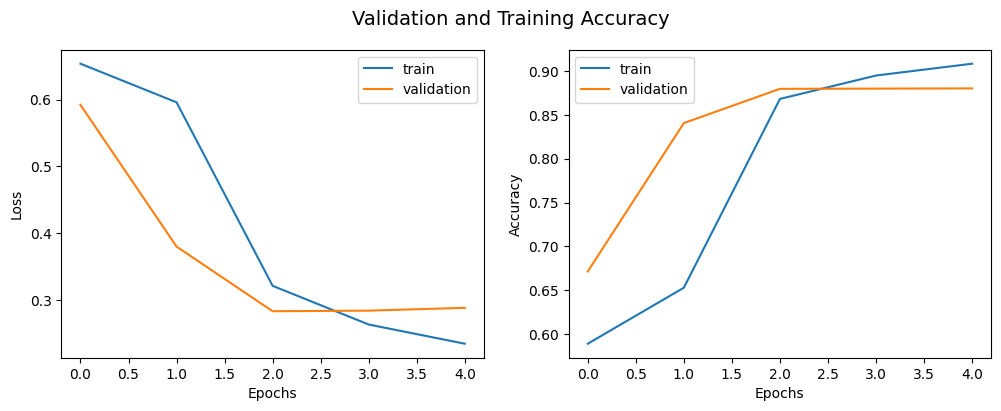

In [24]:
plt.figure(figsize=(12, 4),dpi=100)
plt.suptitle("Training Curves",fontsize=16)
plt.subplot(1, 2, 1)
plt.suptitle("Validation and Training Loss",fontsize=14)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.suptitle("Validation and Training Accuracy",fontsize=14)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

## Obtenemos las predicciones y evaluamos el desempeño de la red

¿Cómo se ven las predicciones?

In [25]:
predictions = model.predict(test_padded)

print(predictions[:5])

313/313 [==============================] - 2s 4ms/step
[[0.42533955]
 [0.6957174 ]
 [0.9683875 ]
 [0.9107865 ]
 [0.3819364 ]]


Como podemos ver, la predicción de la red LSTM para cada review es un valor $0 \leq x \leq 1$ (esto, ya que la activación es una sigmoide). Podemos interpretar este valor como la probabilidad que estima la red de que el review tenga la clase 1 (es decir, que el review tenga opinión "positiva").

Entonces, para obtener las predicciones de las clases, asignamos la clase 1 si $x\geq 0.5$ y clase 0 si $x<0.5$.

In [26]:
pred_labels = []

for x in predictions:
    if x >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)

print(pred_labels[:5])

[0, 1, 1, 1, 0]


Evaluamos la calidad de las predicciones usando el accuracy y el recall.

In [27]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

test_accuracy = accuracy_score(test_labels,pred_labels)
test_recall = recall_score(test_labels,pred_labels)
print(f"Test Accuracy: {round(test_accuracy,3)}")
print(f"Test Recall: {round(test_recall,3)}")

print("\nConfusion Matrix:\n",confusion_matrix(test_labels,pred_labels))

Test Accuracy: 0.874
Test Recall: 0.879

Confusion Matrix:
 [[4418  662]
 [ 595 4325]]


Finalmente, veamos algunas predicciones arbitrarias:

In [28]:
test_size = len(test_reviews)

idxs = np.random.choice(test_size,size=5,replace=False)

for j in idxs:
    print("Review:")
    print(df.loc[j,'review'])
    print(f"Label: {df.loc[j,'sentiment']}")
    print(f"Predicted Label: {pred_labels[j]}\n")

Review:
This is one of the finest films to come out of Hong Kong's 'New Wave' that began with Tsui Hark's "ZU: Warriors of Magic Mountain". Tsui set a tone for the New Wave's approach to the martial arts film that pretty much all the directors of the New Wave (Jackie Chan, Sammo Hung, Wong Jing, Ching Siu Tung, etc.) accepted from then on as a given; namely, the approach to such films thenceforth would need more than a touch of irony, if not outright comedy. "Burning Paradise" put a stop to all that, and with a vengeance.<br /><br />It's not that there isn't humor here; but it is a purely human humor, as with the aged Buddhist priest at the beginning who somehow manages a quick feel of the nubile young prostitute while hiding in a bundle of straw. But this is just as humans are, not even Buddhist priests can be saints all the time.<br /><br />When irony is at last introduced into the film, it is the nastiest possible, emanating from the 'abbot' of Red Lotus Temple, who is a study in pu

# ⭕ Ejercicio:

* Modifica la arquitectura de la LSTM para mejorar el desempeño de la LSTM anterior.
* Puedes usar también capas de dropout, callbacks, modificar las capas densas del final (recuerda que la capa final no se puede mover).

In [111]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout
from keras.layers import LSTM

# ----- model initialization
model = keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(100, dropout=0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='selu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# ----- compile model
model.compile(loss='binary_crossentropy',
              optimizer='adamax',
              metrics=['accuracy'])

model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 200, 100)          300000    
                                                                 
 lstm_20 (LSTM)              (None, 100)               80400     
                                                                 
 dense_48 (Dense)            (None, 32)                3232      
                                                                 
 dropout_17 (Dropout)        (None, 32)                0         
                                                                 
 dense_49 (Dense)            (None, 16)                528       
                                                                 
 dropout_18 (Dropout)        (None, 16)                0         
                                                                 
 dense_50 (Dense)            (None, 1)               

Creamos un callback `EarlyStopping` para parar el entrenamiento de la red cuando la pérdida de validación empiece a aumentar. Observa el parámetro `patience`.

In [112]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

Entrenamos el modelo

In [113]:
num_epochs = 20

history = model.fit(train_padded, train_labels,
                    epochs=num_epochs, verbose=1,
                    validation_split=0.1,
                    callbacks=[es])

Epoch 1/20
1125/1125 [==============================] - 56s 48ms/step - loss: 0.6933 - accuracy: 0.5039 - val_loss: 0.6919 - val_accuracy: 0.5125
Epoch 2/20
1125/1125 [==============================] - 18s 16ms/step - loss: 0.6805 - accuracy: 0.5445 - val_loss: 0.5312 - val_accuracy: 0.7567
Epoch 3/20
1125/1125 [==============================] - 15s 14ms/step - loss: 0.4672 - accuracy: 0.8111 - val_loss: 0.3462 - val_accuracy: 0.8610
Epoch 4/20
1125/1125 [==============================] - 15s 13ms/step - loss: 0.3902 - accuracy: 0.8503 - val_loss: 0.3133 - val_accuracy: 0.8692
Epoch 5/20
1125/1125 [==============================] - 13s 12ms/step - loss: 0.3464 - accuracy: 0.8676 - val_loss: 0.3171 - val_accuracy: 0.8570
Epoch 6/20
1125/1125 [==============================] - 14s 13ms/step - loss: 0.3403 - accuracy: 0.8698 - val_loss: 0.3024 - val_accuracy: 0.8652
Epoch 7/20
1125/1125 [==============================] - 13s 12ms/step - loss: 0.3154 - accuracy: 0.8814 - val_loss: 0.2785 -

Veamos las curvas de entrenamiento

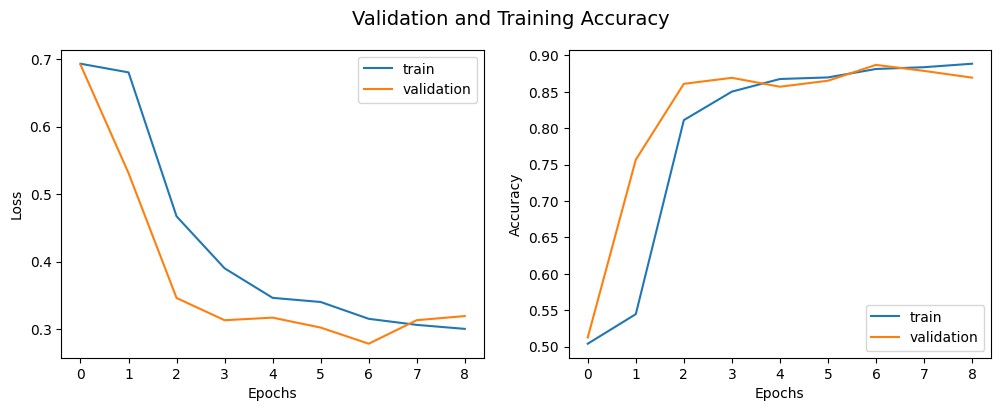

In [114]:
plt.figure(figsize=(12, 4),dpi=100)
plt.suptitle("Training Curves",fontsize=16)
plt.subplot(1, 2, 1)
plt.suptitle("Validation and Training Loss",fontsize=14)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.suptitle("Validation and Training Accuracy",fontsize=14)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

## Obtenemos las predicciones y evaluamos el desempeño de la red

¿Cómo se ven las predicciones?

In [115]:
predictions = model.predict(test_padded)

print(predictions[:5])

313/313 [==============================] - 2s 5ms/step
[[0.6977934 ]
 [0.7699672 ]
 [0.9869266 ]
 [0.9905104 ]
 [0.36829072]]


In [116]:
pred_labels = []

for x in predictions:
    if x >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)

print(pred_labels[:5])

[1, 1, 1, 1, 0]


Evaluamos la calidad de las predicciones usando el accuracy y el recall.

In [117]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

test_accuracy = accuracy_score(test_labels,pred_labels)
test_recall = recall_score(test_labels,pred_labels)
print(f"Test Accuracy: {round(test_accuracy,3)}")
print(f"Test Recall: {round(test_recall,3)}")

print("\nConfusion Matrix:\n",confusion_matrix(test_labels,pred_labels))

Test Accuracy: 0.861
Test Recall: 0.935

Confusion Matrix:
 [[4008 1072]
 [ 320 4600]]
